<a href="https://colab.research.google.com/github/MasaAsami/commentary_mjca/blob/main/notebooks/mjca_simdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# [研究ノート] 法務省ケースアセスメントツールへの批判的検証
- 本ノートブックは研究ノート(「法務省ケースアセスメントツールへの批判的検証」)で使用した分析及び図表を掲載している



In [61]:
# @title パッケージの読み込み {"display-mode":"form"}
import random
from tqdm.notebook import tqdm
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn のスタイルとコンテキストを設定
sns.set_style("ticks")          # クリーンなスタイル
sns.set_context("paper")        # 論文用のコンテキスト設定


In [62]:
# @title Model定義 {"display-mode":"form"}

def generate_random_correlation_matrix(dim, seed=None):
    """
    指定された次元数に基づいてランダムな相関行列を生成する。
    """
    if seed is not None:
        np.random.seed(seed)

    # ランダムな正定値行列を生成
    A = np.random.rand(dim, dim)
    sym_A = (A + A.T) / 2  # 対称行列にする
    eigvals, eigvecs = np.linalg.eigh(sym_A)  # 固有値と固有ベクトルを計算

    # 正の固有値を持つように調整
    positive_eigvals = np.abs(eigvals) + 1e-3  # 小さい値を足してゼロ回避
    positive_definite_matrix = eigvecs @ np.diag(positive_eigvals) @ eigvecs.T

    # 標準化して相関行列に変換
    std_devs = np.sqrt(np.diag(positive_definite_matrix))
    correlation_matrix = positive_definite_matrix / np.outer(std_devs, std_devs)

    return correlation_matrix

class LinearDataGenerator:
    def __init__(self, N=1000, X_dim=10, noise_std=2, seed=42):
        self.N = N
        self.X_dim = X_dim
        self.seed = seed
        self.noise_std = noise_std
        np.random.seed(self.seed)

    def generate_data(self):
        N = self.N
        X_dim =  self.X_dim
        # 特徴量Xの生成
        correlation_matrix = generate_random_correlation_matrix(dim=X_dim, seed=self.seed)
        x_mean = np.zeros(X_dim)
        X = np.random.multivariate_normal(mean=x_mean, cov=correlation_matrix, size=N)
        X = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(X_dim)])

        feature_cols = X.columns.tolist()

        # 処遇Aの割り当て（線形モデル）
        beta = np.random.uniform(-1, 0.5, len(feature_cols))
        logits = X.values @ beta + np.random.normal(0, 0.5, N)
        prob_A = 1 / (1 + np.exp(-logits))
        A = np.random.binomial(1, prob_A)


        # 反実仮想のアウトカムRを生成
        _beta_A0 = np.random.uniform(0, 2, len(feature_cols))
        gamma_A0 = np.abs(_beta_A0) * beta
        _beta_A1 = np.random.uniform(0, 1.5, len(feature_cols))
        gamma_A1 = np.abs(_beta_A1) * beta* -1

        noise = np.random.normal(0, self.noise_std, N)

        # 処遇なしの場合のアウトカム R(A=0)
        logits_R_A0 = X.values @ gamma_A0  +  noise
        prob_R_A0 = 1 / (1 + np.exp(-logits_R_A0))
        R_A0 = np.random.binomial(1, prob_R_A0)

        # 処遇ありの場合のアウトカム R(A=1)
        logits_R_A1 = X.values @ gamma_A1  +  noise
        prob_R_A1 = 1 / (1 + np.exp(-logits_R_A1))
        R_A1 = np.random.binomial(1, prob_R_A1)

        # 観測されたアウトカム R は、実際の処遇 A に対応するもの
        R = np.where(A == 1, R_A1, R_A0)

        # データフレームの作成
        data = X.copy()
        data['A'] = A
        data['R'] = R
        data["true_prob_A"] = prob_A
        data['R_A0'] = R_A0  # 反実仮想のアウトカム
        data['R_A1'] = R_A1  # 反実仮想のアウトカム

        return data, feature_cols[:X_dim]


# DR Policy Optimizer Class
class DRPolicyOptimizer:
    def __init__(self, feature_cols, feature_cols_ps):
        self.feature_cols = feature_cols
        self.feature_cols_ps = feature_cols_ps

    def estimate_ps_model(self, train_data):
        # Estimate propensity score model P(A|X)
        train_features_ps = train_data[self.feature_cols_ps]
        train_target_ps = train_data['A']

        lgb_train_ps = lgb.Dataset(train_features_ps, train_target_ps)
        params_ps = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'seed': 42
        }
        self.model_ps = lgb.train(params_ps, lgb_train_ps, num_boost_round=100)


    def estimate_outcome_model(self, train_data, linear_model=False):
        # Features and target for E[R|X,A]
        train_features_q = train_data[self.feature_cols + ['A']]
        train_target_q = train_data['R']

        if linear_model:
            # Use Logistic Regression for E[R|X,A]
            self.model_q = LogisticRegression(random_state=42, max_iter=1000)
            self.model_q.fit(train_features_q, train_target_q)
        else:
            # Use LightGBM for E[R|X,A]
            lgb_train_q = lgb.Dataset(train_features_q, train_target_q)
            params_q = {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'verbosity': -1,
                'seed': 42
            }
            self.model_q = lgb.train(params_q, lgb_train_q, num_boost_round=100)

    def optimize_policy(self, train_data, num_epochs=100, batch_size=256, plot_show=True):
        # Define policy network
        class PolicyNetwork(nn.Module):
            def __init__(self, input_dim):
                super(PolicyNetwork, self).__init__()
                self.fc = nn.Sequential(
                    nn.Linear(input_dim, 16),
                    nn.ReLU(),
                    nn.Linear(16, 2),
                    nn.Softmax(dim=1)
                )

            def forward(self, x):
                return self.fc(x)

        self.policy_net = PolicyNetwork(input_dim=len(self.feature_cols))
        optimizer = optim.Adam(self.policy_net.parameters(), lr=0.01)

        # Prepare data tensors
        X_tensor = torch.tensor(train_data[self.feature_cols].values, dtype=torch.float)
        A_tensor = torch.tensor(train_data['A'].values, dtype=torch.long)
        R_tensor = torch.tensor(train_data['R'].values, dtype=torch.float)
        ps_tensor = torch.tensor(train_data['ps_hat'].values, dtype=torch.float)
        q_hat_A_tensor = torch.tensor(
            train_data['q_hat_A1'].values * train_data['A'].values +
            train_data['q_hat_A0'].values * (1 - train_data['A'].values), dtype=torch.float)

        # Clamp propensity scores for numerical stability
        ps_tensor = torch.clamp(ps_tensor, 0.05, 0.95)

        num_batches = int(np.ceil(len(train_data) / batch_size))

        for epoch in range(num_epochs):
            perm = np.random.permutation(len(train_data))
            X_tensor = X_tensor[perm]
            A_tensor = A_tensor[perm]
            R_tensor = R_tensor[perm]
            ps_tensor = ps_tensor[perm]
            q_hat_A_tensor = q_hat_A_tensor[perm]

            for i in range(num_batches):
                start = i * batch_size
                end = min((i + 1) * batch_size, len(train_data))

                X_batch = X_tensor[start:end]
                A_batch = A_tensor[start:end]
                R_batch = R_tensor[start:end]
                ps_batch = ps_tensor[start:end]
                q_hat_batch = q_hat_A_tensor[start:end]

                optimizer.zero_grad()

                # Policy network output
                pi_probs = self.policy_net(X_batch)

                # Probability of selected action
                pi_a = pi_probs.gather(1, A_batch.view(-1,1)).squeeze()

                # Compute Q-values
                indices = perm[start:end]
                q_hat_A1 = torch.tensor(train_data['q_hat_A1'].values[indices], dtype=torch.float)
                q_hat_A0 = torch.tensor(train_data['q_hat_A0'].values[indices], dtype=torch.float)

                # Compute value function V(pi)
                V_pi = ((pi_a / ps_batch) * (R_batch - q_hat_batch) +
                        pi_probs[:,1] * q_hat_A1 + pi_probs[:,0] * q_hat_A0).mean()

                # Backpropagation
                V_pi.backward()
                optimizer.step()

            # Optional: print loss every 10 epochs
            if (epoch + 1) % 10 == 0:
                if plot_show:
                    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {V_pi.item():.4f}")

        self.optimizer = optimizer  # Save optimizer if needed

    def apply_policy(self, data):
        # Apply learned policy to data
        X_tensor = torch.tensor(data[self.feature_cols].values, dtype=torch.float)
        with torch.no_grad():
            pi_probs = self.policy_net(X_tensor)
            pi_probs = pi_probs.numpy()

        data['A_policy'] = np.argmax(pi_probs, axis=1)
        return data

# DR Policy Optimizer Class
class MJCA:
    def __init__(self, feature_cols):
        self.feature_cols = feature_cols

    def estimate_outcome_model(self, train_data):
        # Estimate outcome model E[R|X]
        train_features_q = train_data[self.feature_cols]
        train_target_q = train_data['R']

        lgb_train_q = lgb.Dataset(train_features_q, train_target_q)
        params_q = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'seed': 42
        }
        self.model_q = lgb.train(params_q, lgb_train_q, num_boost_round=100)

        # Also estimate outcome model E[R|X] for Case 1
        train_features_q_x = train_data[self.feature_cols]
        lgb_train_q_x = lgb.Dataset(train_features_q_x, train_target_q)
        self.model_q_x = lgb.train(params_q, lgb_train_q_x, num_boost_round=100)



# 基本EDA

In [63]:
N = 6000
X_dim = 52
noise_std = 5
sim = 0
data_generator = LinearDataGenerator(N=N, X_dim=X_dim, noise_std=noise_std, seed=sim)
data, feature_cols_ps = data_generator.generate_data()
feature_cols = feature_cols_ps

# データ分割
train_data, test_data = train_test_split(data, test_size=0.3, random_state=sim)

# DRPolicyOptimizerの初期化
dr_optimizer = DRPolicyOptimizer(feature_cols, feature_cols_ps)
mjca = MJCA(feature_cols)

# モデルの推定
dr_optimizer.estimate_ps_model(train_data)
dr_optimizer.estimate_outcome_model(train_data)
mjca.estimate_outcome_model(train_data)

# 学習データでの傾向スコアとQ値の予測
train_data['ps_hat'] = dr_optimizer.model_ps.predict(train_data[feature_cols_ps])
train_data['q_hat_A1'] = dr_optimizer.model_q.predict(train_data[feature_cols].assign(A=1))
train_data['q_hat_A0'] = dr_optimizer.model_q.predict(train_data[feature_cols].assign(A=0))

# ポリシーの最適化
_batch_size =  max(200, min(2000, N // 10))
dr_optimizer.optimize_policy(train_data, num_epochs=100, batch_size=_batch_size, plot_show=False)

# テストデータでの予測
test_data['ps_hat'] = dr_optimizer.model_ps.predict(test_data[feature_cols_ps])
test_data['q_hat_A1'] = dr_optimizer.model_q.predict(test_data[feature_cols].assign(A=1))
test_data['q_hat_A0'] = dr_optimizer.model_q.predict(test_data[feature_cols].assign(A=0))
test_data = dr_optimizer.apply_policy(test_data)

# ケース1：E[R|X]
test_data['R_hat_case1'] = mjca.model_q_x.predict(test_data[feature_cols])
test_data['A_case1'] = (test_data['R_hat_case1'] >= 0.2).astype(int)
test_data['R_case1'] = np.where(test_data['A_case1'] == 1, test_data['R_A1'], test_data['R_A0'])


In [64]:
test_data["R_hat_case2"] = test_data['q_hat_A1']*test_data['A'] + test_data['q_hat_A0']*(1-test_data['A'])
test_data["R_hat_case2_class"] = (test_data["R_hat_case2"] >= 0.2).astype(int)

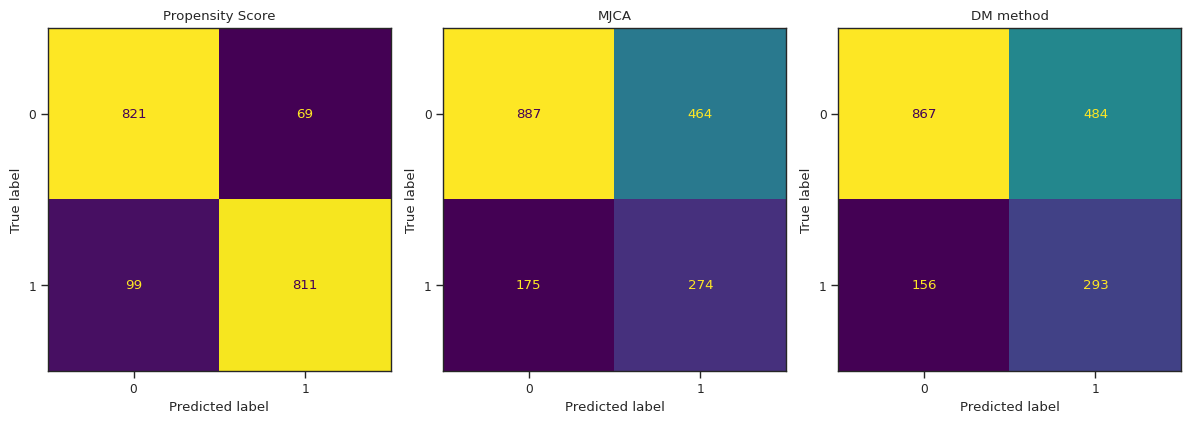

       Model  Accuracy    Recall  Precision
0       MJCA  0.645000  0.610245   0.371274
1  DM method  0.644444  0.652561   0.377091


In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
# 例: データの読み込み

test_data["R_hat_case2"]

# 混同行列を計算
conf_matrix_case0 = confusion_matrix(test_data["A"], (test_data["ps_hat"] >= 0.5).astype(int))
conf_matrix_case1 = confusion_matrix(test_data["R"], test_data["A_case1"])
conf_matrix_case2 = confusion_matrix(test_data["R"], test_data["R_hat_case2_class"])

# モデルごとの評価指標を計算
metrics = {
    "Model": ["MJCA", "DM method"],
    "Accuracy": [
        accuracy_score(test_data["R"], test_data["A_case1"]),
        accuracy_score(test_data["R"], test_data["R_hat_case2_class"]),
    ],
    "Recall": [
        recall_score(test_data["R"], test_data["A_case1"]),
        recall_score(test_data["R"], test_data["R_hat_case2_class"]),
    ],
    "Precision": [
        precision_score(test_data["R"], test_data["A_case1"]),
        precision_score(test_data["R"], test_data["R_hat_case2_class"]),
    ],
}
metrics_df = pd.DataFrame(metrics)

# 混同行列のプロット
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
ConfusionMatrixDisplay(conf_matrix_case0, display_labels=["0", "1"]).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Propensity Score")

ConfusionMatrixDisplay(conf_matrix_case1, display_labels=["0", "1"]).plot(ax=axes[1], colorbar=False)
axes[1].set_title("MJCA")

ConfusionMatrixDisplay(conf_matrix_case2, display_labels=["0", "1"]).plot(ax=axes[2], colorbar=False)
axes[2].set_title("DM method")

plt.tight_layout()
plt.show()

# 評価指標を表示
print(metrics_df)

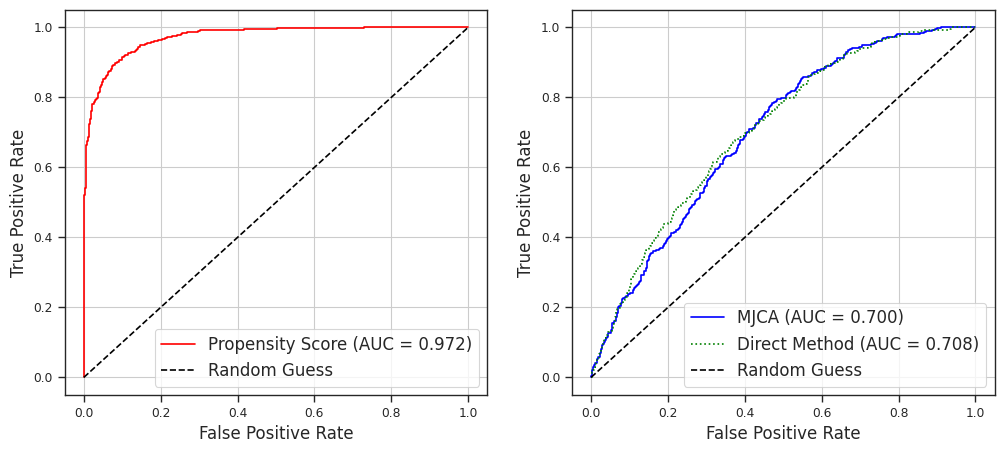

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# ROC曲線とAUCスコア
fpr, tpr, thresholds = roc_curve(test_data['A'], test_data['ps_hat'])
auc_score = roc_auc_score(test_data['A'], test_data['ps_hat'])

axes[0].plot(fpr, tpr, color='red', label=f'Propensity Score (AUC = {auc_score:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid()


# アウトカムモデルのROC曲線とAUCスコア
fpr, tpr, thresholds = roc_curve(test_data['R'], test_data['R_hat_case1'])
auc_score = roc_auc_score(test_data['R'], test_data['R_hat_case1'])

fpr_q, tpr_q, thresholds_q = roc_curve(test_data['R'], test_data['R_hat_case2'])
auc_score_q = roc_auc_score(test_data['R'], test_data['R_hat_case2'])

# ROC曲線をプロット
axes[1].plot(fpr, tpr, color='blue', label=f'MJCA (AUC = {auc_score:.3f})')
axes[1].plot(fpr_q, tpr_q, ':',color='green',label=f'Direct Method (AUC = {auc_score_q:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('', fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid()
plt.savefig('roc_plots.png', dpi=300)
plt.show()

In [67]:
# @title シミュレーション関数定義
from joblib import Parallel, delayed

def simulate_single_run(sim, N, X_dim, noise_std):
    """
    1回のシミュレーションを実行。
    """
    # データ生成
    data_generator = LinearDataGenerator(N=N, X_dim=X_dim, noise_std=noise_std, seed=sim)
    data, feature_cols_ps = data_generator.generate_data()
    feature_cols = feature_cols_ps

    # データ分割
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=sim)

    # DRPolicyOptimizerの初期化
    dr_optimizer = DRPolicyOptimizer(feature_cols, feature_cols_ps)
    mjca = MJCA(feature_cols)

    # モデルの推定
    dr_optimizer.estimate_ps_model(train_data)
    dr_optimizer.estimate_outcome_model(train_data)
    mjca.estimate_outcome_model(train_data)

    # 学習データでの傾向スコアとQ値の予測
    lower_bound = 0.05  # 傾向スコア下限
    upper_bound = 0.95  # 傾向スコア上限

    train_data['ps_hat'] = dr_optimizer.model_ps.predict(train_data[feature_cols_ps])
    train_data['ps_hat'] = np.clip(train_data['ps_hat'], lower_bound, upper_bound)
    train_data['q_hat_A1'] = dr_optimizer.model_q.predict(train_data[feature_cols].assign(A=1))
    train_data['q_hat_A0'] = dr_optimizer.model_q.predict(train_data[feature_cols].assign(A=0))

    # ポリシーの最適化
    _batch_size =  max(200, min(2000, N // 10))
    dr_optimizer.optimize_policy(train_data, num_epochs=100, batch_size=_batch_size, plot_show=False)

    # テストデータでの予測
    test_data['ps_hat'] = dr_optimizer.model_ps.predict(test_data[feature_cols_ps])
    test_data['ps_hat'] = np.clip(test_data['ps_hat'], lower_bound, upper_bound)
    test_data['q_hat_A1'] = dr_optimizer.model_q.predict(test_data[feature_cols].assign(A=1))
    test_data['q_hat_A0'] = dr_optimizer.model_q.predict(test_data[feature_cols].assign(A=0))
    test_data = dr_optimizer.apply_policy(test_data)

    # ケースごとの計算
    results = {}
    # ケース0：理想的な再犯率
    test_data['A_ideal'] = (test_data['R_A1'] < test_data['R_A0']).astype(int)
    test_data['R_case0'] = np.where(test_data['A_ideal'] == 1, test_data['R_A1'], test_data['R_A0'])
    results['Case0'] = test_data['R_case0'].mean()

    # ケース1：E[R|X]
    test_data['R_hat_case1'] = mjca.model_q_x.predict(test_data[feature_cols])
    test_data['A_case1'] = (test_data['R_hat_case1'] >= 0.2).astype(int)
    test_data['R_case1'] = np.where(test_data['A_case1'] == 1, test_data['R_A1'], test_data['R_A0'])
    results['Case1'] = test_data['R_case1'].mean()

    # ケース2：E[R|X,A]
    test_data['A_case2'] = (test_data['q_hat_A1'] < test_data['q_hat_A0']).astype(int)
    test_data['R_case2'] = np.where(test_data['A_case2'] == 1, test_data['R_A1'], test_data['R_A0'])
    results['Case2'] = test_data['R_case2'].mean()

    # ケース3：OPL (DR 推定)
    test_data['R_case3'] = np.where(test_data['A_policy'] == 1, test_data['R_A1'], test_data['R_A0'])
    results['Case3'] = test_data['R_case3'].mean()

    return results


# サンプル別検証

In [68]:
# 並列実行
sample_sizes = [500, 2000 , 4000, 6000, 8000, 10000]
sample_results = {N: {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []} for N in sample_sizes}
X_dim = 52
noise_std = 5
num_simulations = 1000 # 各サンプルサイズでのシミュレーション回数
for N in sample_sizes:
    print(f"\nSample Size N={N}")
    parallel_results = Parallel(n_jobs=-1)(delayed(simulate_single_run)(sim, N, X_dim, noise_std) for sim in tqdm(range(num_simulations), dynamic_ncols=True))
    # 結果を集計
    for _case in ['Case0', 'Case1', 'Case2', 'Case3']:
        sample_results[N][_case] = [result[_case] for result in parallel_results]



Sample Size N=500


  0%|          | 0/1000 [00:00<?, ?it/s]


Sample Size N=2000


  0%|          | 0/1000 [00:00<?, ?it/s]


Sample Size N=4000


  0%|          | 0/1000 [00:00<?, ?it/s]


Sample Size N=6000


  0%|          | 0/1000 [00:00<?, ?it/s]


Sample Size N=8000


  0%|          | 0/1000 [00:00<?, ?it/s]


Sample Size N=10000


  0%|          | 0/1000 [00:00<?, ?it/s]

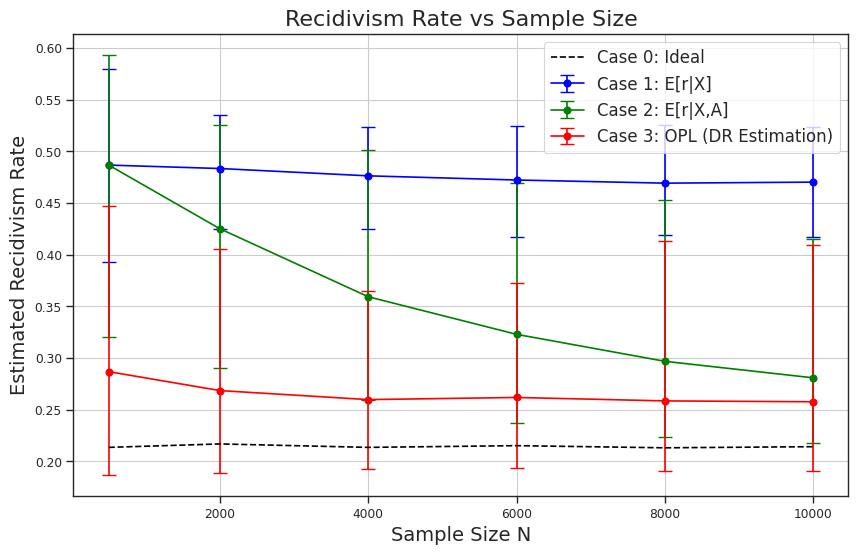

In [69]:
# 各ケースの中央値と信頼区間の計算
median_results = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}
lower_bounds = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}
upper_bounds = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}

for _case in ['Case0', 'Case1', 'Case2', 'Case3']:
    for N in sample_sizes:
        data = np.array(sample_results[N][_case])
        median = np.median(data)
        lower = np.percentile(data, 2.5)
        upper = np.percentile(data, 97.5)

        median_results[_case].append(median)
        lower_bounds[_case].append(lower)
        upper_bounds[_case].append(upper)

# プロットの作成
plt.figure(figsize=(10, 6))

for _case, label, color in zip(['Case1', 'Case2', 'Case3'],
                              ['Case 1: E[r|X]', 'Case 2: E[r|X,A]', 'Case 3: OPL (DR Estimation)'],
                              ['blue', 'green', 'red']):
    medians = median_results[_case]
    lowers = lower_bounds[_case]
    uppers = upper_bounds[_case]
    plt.errorbar(sample_sizes, medians, yerr=[np.array(medians) - np.array(lowers), np.array(uppers) - np.array(medians)],
                 fmt='-o', label=label, color=color, capsize=5)

# 理想的な再犯率をプロット
ideal_medians = median_results['Case0']
plt.plot(sample_sizes, ideal_medians, 'k--', label='Case 0: Ideal')

plt.xlabel('Sample Size N', fontsize=14)
plt.ylabel('Estimated Recidivism Rate', fontsize=14)
plt.title('Recidivism Rate vs Sample Size', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# ノイズの検証

In [70]:
# 並列実行
sample_size = 6000
noise_levels = [3, 4, 5, 6, 7]
noise_results = {noise_std: {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []} for noise_std in noise_levels }
X_dim = 52
num_simulations = 1000 # 各サンプルサイズでのシミュレーション回数
for noise_std in noise_levels:
    print(f"\nNoise STD ={noise_std}")
    parallel_results = Parallel(n_jobs=-1)(delayed(simulate_single_run)(sim, sample_size, X_dim, noise_std) for sim in tqdm(range(num_simulations), dynamic_ncols=True))
    # 結果を集計
    for _case in ['Case0', 'Case1', 'Case2', 'Case3']:
        noise_results[noise_std][_case] = [result[_case] for result in parallel_results]


Noise STD =3


  0%|          | 0/1000 [00:00<?, ?it/s]


Noise STD =4


  0%|          | 0/1000 [00:00<?, ?it/s]


Noise STD =5


  0%|          | 0/1000 [00:00<?, ?it/s]


Noise STD =6


  0%|          | 0/1000 [00:00<?, ?it/s]


Noise STD =7


  0%|          | 0/1000 [00:00<?, ?it/s]

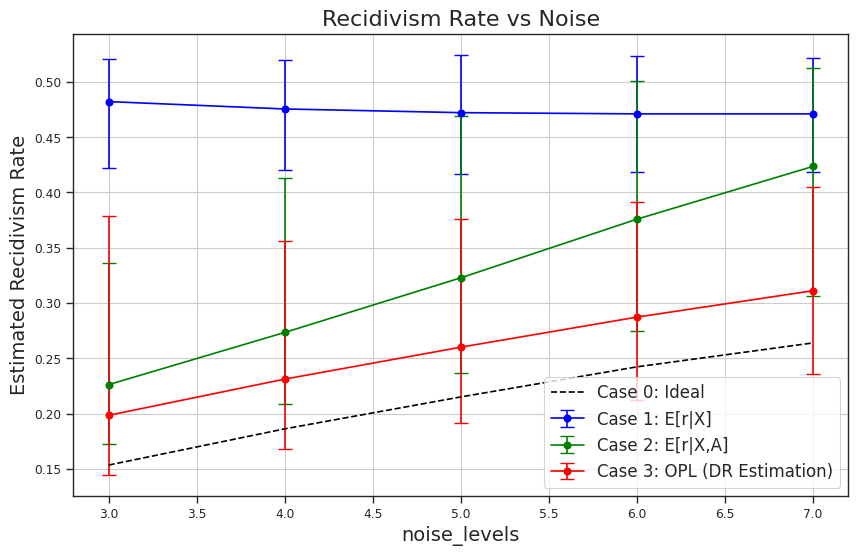

In [71]:
# 各ケースの中央値と信頼区間の計算
median_results = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}
lower_bounds = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}
upper_bounds = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}

for _case in ['Case0', 'Case1', 'Case2', 'Case3']:
    for noise_std in noise_levels:
        data = np.array(noise_results[noise_std][_case])
        median = np.median(data)
        lower = np.percentile(data, 2.5)
        upper = np.percentile(data, 97.5)

        median_results[_case].append(median)
        lower_bounds[_case].append(lower)
        upper_bounds[_case].append(upper)

# プロットの作成
plt.figure(figsize=(10, 6))

for _case, label, color in zip(['Case1', 'Case2', 'Case3'],
                              ['Case 1: E[r|X]', 'Case 2: E[r|X,A]', 'Case 3: OPL (DR Estimation)'],
                              ['blue', 'green', 'red']):
    medians = median_results[_case]
    lowers = lower_bounds[_case]
    uppers = upper_bounds[_case]
    plt.errorbar(noise_levels, medians, yerr=[np.array(medians) - np.array(lowers), np.array(uppers) - np.array(medians)],
                 fmt='-o', label=label, color=color, capsize=5)

# 理想的な再犯率をプロット
ideal_medians = median_results['Case0']
plt.plot(noise_levels, ideal_medians, 'k--', label='Case 0: Ideal')

plt.xlabel('noise_levels', fontsize=14)
plt.ylabel('Estimated Recidivism Rate', fontsize=14)
plt.title('Recidivism Rate vs Noise', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

<ipython-input-76-249b13ab9963>:67: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(
<ipython-input-76-249b13ab9963>:67: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(
<ipython-input-76-249b13ab9963>:67: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(
<ipython-input-76-249b13ab9963>:101: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(
<ipython-input-76-249b13ab9963>:101: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument 

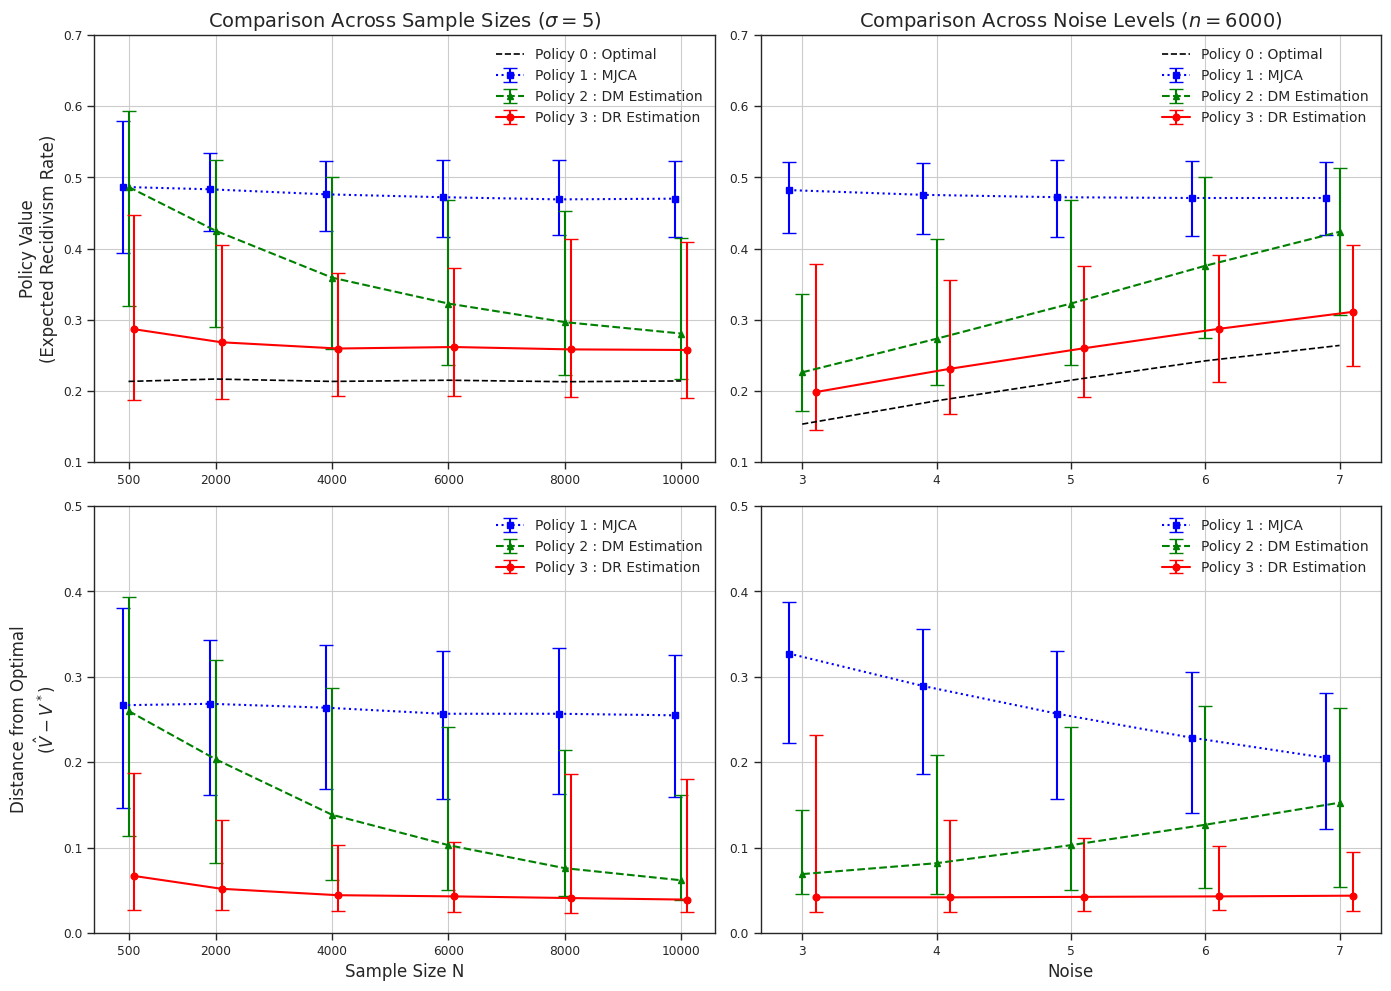

In [76]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def plot_data(results, param_levels, cases):
    # 各ケースの中央値と信頼区間の計算
    median_results = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}
    lower_bounds = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}
    upper_bounds = {'Case0': [], 'Case1': [], 'Case2': [], 'Case3': []}

    for _case in ['Case0', 'Case1', 'Case2', 'Case3']:
        for param in  param_levels:
            data = np.array(results[param][_case])
            median = np.median(data)
            lower = np.percentile(data, 2.5)
            upper = np.percentile(data, 97.5)

            median_results[_case].append(median)
            lower_bounds[_case].append(lower)
            upper_bounds[_case].append(upper)
    return median_results, lower_bounds, upper_bounds


def diff_data(results, param_levels, cases):
    diff_median_results = {_case: [] for _case in cases}
    diff_lower_bounds = {_case: [] for _case in cases}
    diff_upper_bounds = {_case: [] for _case in cases}
    for _case in cases:
        for i, param in enumerate(param_levels):
            diff_data = np.array(results[param][_case]) - np.array(results[param]['Case0'])
            median = np.median(diff_data)
            lower = np.percentile(diff_data, 2.5)
            upper = np.percentile(diff_data, 97.5)

            diff_median_results[_case].append(median)
            diff_lower_bounds[_case].append(lower)
            diff_upper_bounds[_case].append(upper)
    return diff_median_results, diff_lower_bounds, diff_upper_bounds




# 既存の結果が 'results' 辞書に格納されているとします。
# 'results' はサンプルサイズをキーとし、各ケースの結果をリストとして持つ辞書です。
# 色の代わりにマーカーとラインスタイルを使用

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
cases = ['Case0', 'Case1', 'Case2', 'Case3']
labels = ['Policy 0 : Optimal', 'Policy 1 : MJCA', 'Policy 2 : DM Estimation', 'Policy 3 : DR Estimation']
colors = ['black', 'blue', 'green', 'red']
line_styles = ['-.', ':', '--','-']
markers = ['s', 's', '^', 'o']
ax = axes[0,0]

median_results, lower_bounds, upper_bounds = plot_data(sample_results, sample_sizes, cases)
# 水平オフセットの値（ケースごとに調整）
offset = 100  # オフセット幅（適宜調整）
case_offsets = [0 ,-offset, 0, offset]  # 各ケースのオフセット
for i, (_case, _label, _color) in enumerate(zip(cases, labels, colors)):
    if _case == "Case0":
        continue
    # サンプルサイズをケースごとにずらす
    adjusted_sample_sizes = [size + case_offsets[i] for size in sample_sizes]
    medians = median_results[_case]
    lowers = lower_bounds[_case]
    uppers = upper_bounds[_case]

    ax.errorbar(
        adjusted_sample_sizes, medians, yerr=[np.array(medians) - np.array(lowers), np.array(uppers) - np.array(medians)],
                 fmt=f"{markers[i]}-", label=_label, color=_color, capsize=5, linestyle=line_styles[i],
        linewidth=1.5
        )

# 軸とラベルの調整
# 理想的な再犯率をプロット
ax.set_xticks(sample_sizes)  # 元のサンプルサイズで目盛りを設定
ax.set_xticklabels(sample_sizes)

ideal_medians = median_results['Case0']
ax.plot(sample_sizes, ideal_medians, 'k--', label=labels[0])
ax.set_ylabel('Policy Value\n(Expected Recidivism Rate)', fontsize=12)
ax.set_title('Comparison Across Sample Sizes ($\sigma = 5$)', fontsize=14)
ax.legend(fontsize=10, frameon=False)
ax.set_ylim(0.1, 0.7)
ax.grid(True)

ax = axes[0,1]

median_results, lower_bounds, upper_bounds = plot_data(noise_results, noise_levels, cases)
# 水平オフセットの値（ケースごとに調整）
offset = 0.1  # オフセット幅（適宜調整）
case_offsets = [0 ,-offset, 0, offset]  # 各ケースのオフセット
for i, (_case, _label, _color) in enumerate(zip(cases, labels, colors)):
    if _case == "Case0":
        continue
    # サンプルサイズをケースごとにずらす
    adjusted_noise_levels = [_noise + case_offsets[i] for _noise in noise_levels]
    medians = median_results[_case]
    lowers = lower_bounds[_case]
    uppers = upper_bounds[_case]

    ax.errorbar(
        adjusted_noise_levels, medians, yerr=[np.array(medians) - np.array(lowers), np.array(uppers) - np.array(medians)],
                 fmt=f"{markers[i]}-", label=_label, color=_color, capsize=5, linestyle=line_styles[i],
        linewidth=1.5
        )

# 軸とラベルの調整
# 理想的な再犯率をプロット
ax.set_xticks(noise_levels)  # 元のサンプルサイズで目盛りを設定
ax.set_xticklabels(noise_levels)

ideal_medians = median_results['Case0']
ax.plot(noise_levels, ideal_medians, 'k--', label=labels[0])
ax.set_title('Comparison Across Noise Levels ($n = 6000$)', fontsize=14)
ax.legend(fontsize=10, frameon=False)
ax.set_ylim(0.1, 0.7)
ax.grid(True)



# ------
# ここから差分プロット
# ケース名と対応するラベル、色の設定
cases = ['Case1', 'Case2', 'Case3']
labels = ['Policy 1 : MJCA', 'Policy 2 : DM Estimation', 'Policy 3 : DR Estimation']
colors = ['blue', 'green', 'red']
line_styles = [':', '--','-']
markers = ['s', '^', 'o']
ax = axes[1,0]

diff_median_results, diff_lower_bounds, diff_upper_bounds = diff_data(sample_results, sample_sizes, cases)

# 水平オフセットの値（ケースごとに調整）
offset = 100  # オフセット幅（適宜調整）
case_offsets = [-offset, 0, offset]  # 各ケースのオフセット
for i, (_case, _label, _color) in enumerate(zip(cases, labels, colors)):
    # サンプルサイズをケースごとにずらす
    adjusted_sample_sizes = [size + case_offsets[i] for size in sample_sizes]
    medians = diff_median_results[_case]
    lowers = diff_lower_bounds[_case]
    uppers = diff_upper_bounds[_case]

    ax.errorbar(
        adjusted_sample_sizes,  # ケースごとにずらしたサンプルサイズ
        medians,
        yerr=[
            np.array(medians) - np.array(lowers),
            np.array(uppers) - np.array(medians)
        ],
        fmt=f"{markers[i]}-",  # マーカーと線スタイル
        label=_label,
        color=_color,
        linestyle=line_styles[i],  # ラインスタイル
        capsize=5,  # エラーバーのキャップサイズ
        linewidth=1.5
    )

# 軸とラベルの調整
ax.set_xticks(sample_sizes)  # 元のサンプルサイズで目盛りを設定
ax.set_xticklabels(sample_sizes)
ax.set_xlabel('Sample Size N', fontsize=12)
ax.set_ylabel('Distance from Optimal\n($\hat{V} - V^*$)', fontsize=12)
ax.legend(fontsize=10, frameon=False)
ax.set_ylim(0.0, 0.5)
ax.grid(True)

#
ax = axes[1,1]


diff_median_results, diff_lower_bounds, diff_upper_bounds = diff_data(noise_results, noise_levels, cases)

# 水平オフセットの値（ケースごとに調整）
offset = 0.1  # オフセット幅（適宜調整）
case_offsets = [-offset, 0, offset]  # 各ケースのオフセット

for i, (_case, _label, _color) in enumerate(zip(cases, labels, colors)):
    # サンプルサイズをケースごとにずらす
    adjusted_noise_levels = [_noise + case_offsets[i] for _noise in noise_levels]
    medians = diff_median_results[_case]
    lowers = diff_lower_bounds[_case]
    uppers = diff_upper_bounds[_case]

    ax.errorbar(
        adjusted_noise_levels,  # ケースごとにずらしたサンプルサイズ
        medians,
        yerr=[
            np.array(medians) - np.array(lowers),
            np.array(uppers) - np.array(medians)
        ],
        fmt=f"{markers[i]}-",  # マーカーと線スタイル
        label=_label,
        color=_color,
        linestyle=line_styles[i],  # ラインスタイル
        capsize=5,  # エラーバーのキャップサイズ
        linewidth=1.5
    )

# 軸とラベルの調整
ax.set_xticks(noise_levels)  # 元のサンプルサイズで目盛りを設定
ax.set_xticklabels(noise_levels)
ax.set_xlabel('Noise', fontsize=12)

ax.legend(fontsize=10, frameon=False)
ax.set_ylim(0.0, 0.5)
ax.grid(True)

# 全体のレイアウト調整
plt.tight_layout()

# プロットの保存（ジャーナル用）
plt.savefig('recidivism_errorbar_for_parper.png', dpi=300, format='png', bbox_inches='tight')

# プロットの表示
plt.show()

# 簡易シミュレーションバージョン


Optimization terminated successfully.
         Current function value: 0.631757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584121
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      r   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Mon, 09 Dec 2024   Pseudo R-squ.:                 0.07507
Time:                        06:27:50   Log-Likelihood:                -631.76
converged:                       True   LL-Null:                       -683.03
Covariance Type:            nonrobust   LLR p-value:                 5.396e-23
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const 

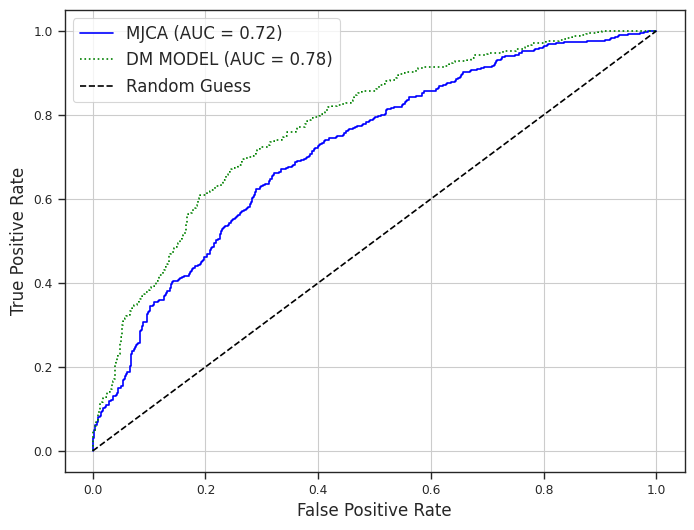

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score

# データ生成プロセス
def generate_simple_data(N=2000, train_ratio=0.5, seed=1):
    np.random.seed(seed)
    # 特徴量 x ("強盗犯罪" フラグ)
    x = np.random.binomial(1, 0.1, N)  # 強盗: 1, その他: 0
    x2 = np.random.normal(0, 1, N) # np.random.binomial(1, 0.5, N)

    # 傾向スコア π_0(a=1 | x="強盗")
    pi_0 = 0.7 * x + 0.25 * (1 - x)

    # 処置 a (少年院送致)
    a = np.random.binomial(1, pi_0, N)

    # ノイズ ε
    epsilon = np.random.normal(0, 1, N)

    # アウトカム r
    z = - 1 * a + 0.5 * x - 0.5 * x2+ epsilon
    r = 1 / (1 + np.exp(-z))  # シグモイド関数

    # 観測されたアウトカム r を 0/1 の離散値に変換
    r_binary = (r > 0.5).astype(int)

    # データフレームの作成
    data = pd.DataFrame({'x': x, 'x2' : x2,'a': a, 'r': r_binary})

    # データを分割
    train_size = int(N * train_ratio)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    return train_data, test_data

# データ生成
train_data, test_data = generate_simple_data(seed=2025)

# MJCAモデル (E[r | x]) を学習 (statsmodels を使用)
X_train = sm.add_constant(train_data[['x', 'x2']])  # 定数項を追加
y_train = train_data['r']
mjca_model = sm.Logit(y_train, X_train).fit()
q_model = sm.Logit(y_train, sm.add_constant(train_data[['x', 'x2', 'a']])).fit()

# モデルの要約を表示
print(mjca_model.summary())
print(q_model.summary())

# テストデータの予測
X_test = sm.add_constant(test_data[['x', 'x2']])
test_data['r_pred'] = mjca_model.predict(X_test)

X_test_q = sm.add_constant(test_data[['x', 'x2', 'a']])
test_data['r_pred_q'] = q_model.predict(X_test_q)

# ROC曲線とAUCスコア
fpr, tpr, thresholds = roc_curve(test_data['r'], test_data['r_pred'])
auc_score = roc_auc_score(test_data['r'], test_data['r_pred'])

fpr_q, tpr_q, thresholds_q = roc_curve(test_data['r'], test_data['r_pred_q'])
auc_score_q = roc_auc_score(test_data['r'], test_data['r_pred_q'])

# ROC曲線をプロット
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'MJCA (AUC = {auc_score:.2f})')
plt.plot(fpr_q, tpr_q, ':',color='green',label=f'DM MODEL (AUC = {auc_score_q:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('simple_sim_plots.png', dpi=300)
plt.show()